# Accelerated Machine Learning

Welcome to the Accelerated Machine Learning course at AIMS 2025.

This tutorial is based on the hls4ml tutorial notebooks (https://github.com/fastmachinelearning/hls4ml-tutorial/). The dataset is described in more detail in this article (https://iopscience.iop.org/article/10.1088/1748-0221/13/07/P07027/pdf). By the end of the course you will have:

* Trained a neural network to identify different types of "jets" at the Large Hadron Collider
* Used the hls4ml python library to convert the neural network to FPGA firmware
* Examined the FPGA resource usage for the neural network
* Understood floating point vs fixed point precision and the implications for inference accuracy and resource usage
* Implemented quantization-aware training using the QKeras library
* Tested the effect of "pruning" on the inference accuray and resource usage

## Part 1: Understanding the jet-tagging dataset

In this section we will import the dependencies and load the jet-tagging dataset. Following this we will take some time to understand the physics involved.

* **Pro-tip**: always understand your dataset!

In [3]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import os
from matplotlib import pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os
import ndjson

Jets are one of the most important objects that we reconstruct at the Large Hadron Collider experiments. 
When fundamental particles, known as quarks or gluons, are produced in the proton-proton collisions,
they undergo a process called "hadronisation".
This creates narrow sprays of particles (hadrons) which are referred to as "jets".
By reconstructing and understanding these jets, we can infer properties of the fundamental particle interactions.
The image below shows a reconstruction of a collision event which produces two back-to-back jets with extremely high energy in the CMS detector.

<img src="figures/event_display_dijet.png" alt="Dijet event display" width="400"/>

In [55]:
# Load the dataset
data = fetch_openml('hls4ml_lhc_jets_hlf', as_frame=False, parser='liac-arff')
X, y = data['data'], data['target']
labels = np.unique(y)
features = data['feature_names']

print("Number of jets:", len(X))
print("Number of features:", len(features))
print("Different target classes:", labels)

Number of jets: 830000
Number of features: 16
Different target classes: ['g' 'q' 't' 'w' 'z']


These correspond to jets produced from a gluon (q), light-quark (q), top-quark (b), W-boson decay (w) and a Z-boson decay (z). 
Jets from the different classes will have different properties, and we can use these for identification.
A summary of the properties included in the dataset is provided in the table below.

<img src="figures/table_observables.png" alt="Table of observables" width="100"/>

The properties are described in more detail in this reference (https://arxiv.org/abs/1709.08705), but it is not important for you to know the exact details for this tutorial. Just that we have five different classes to predict, each of which have a different distribution in the high-dimensional jet property phase space.

Let's have a look at the 1D distributions for the different classes.

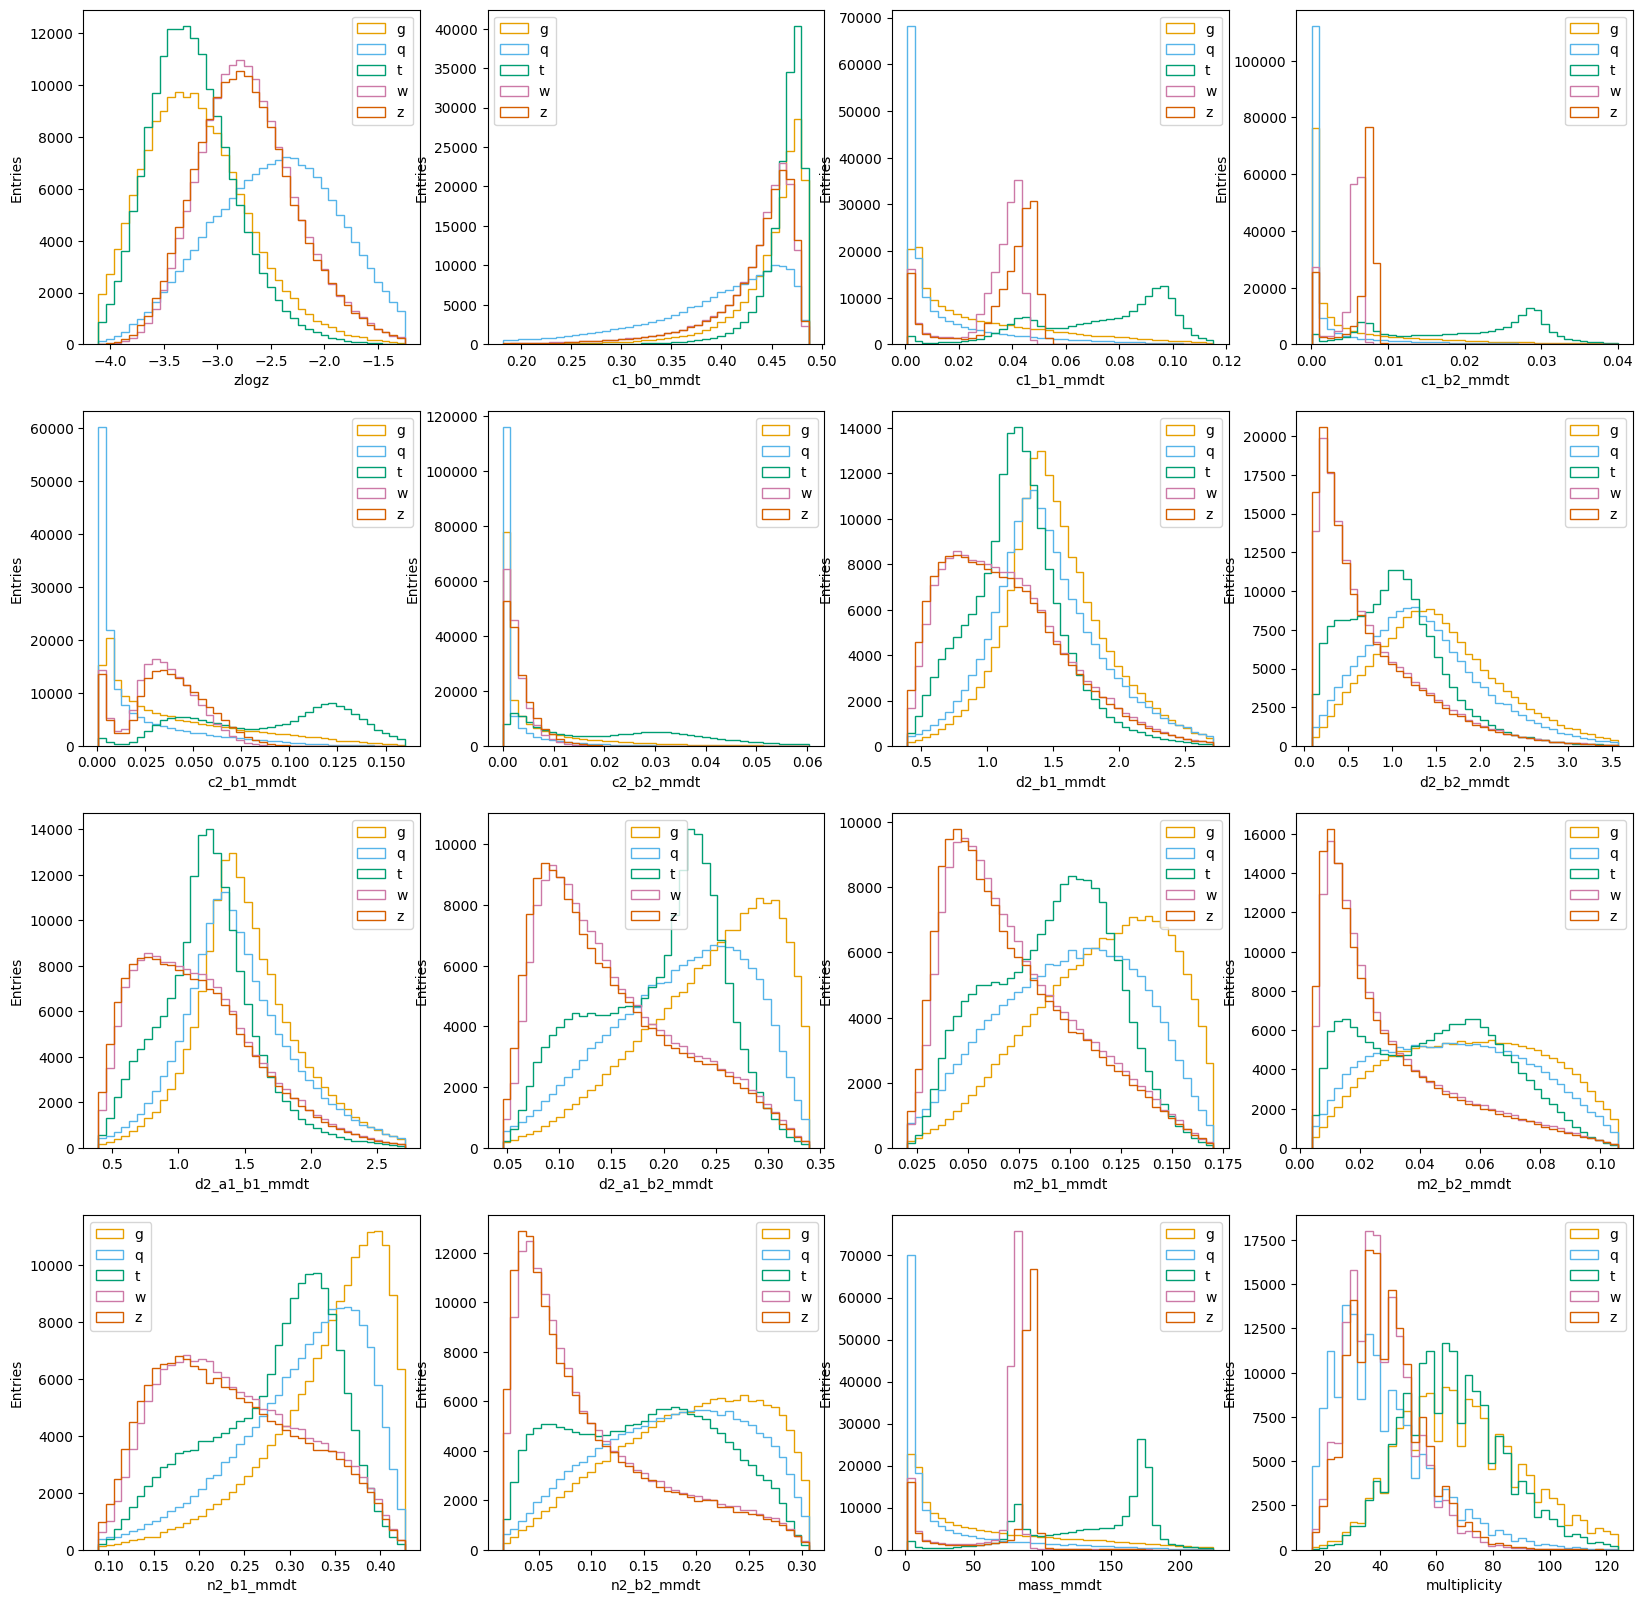

In [56]:
colors = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # green
    "#CC79A7",  # pink/purple
    "#D55E00",  # red/orange
]

def plot_input_feature(ax, X, y, features, x="zlogz", classes=['g','q','t','w','z'], bins=40):
    fi = np.where(np.array(features)==x)[0][0]
    vals = X.T[fi]

    # Obtain percentiles for sensible plot
    xlo, xhi = np.percentile(vals,0.5), np.percentile(vals,99.5)

    for i, c in enumerate(classes):
        mask = (y == c)
        ax.hist(vals[mask], bins=bins, range=(xlo,xhi), label=c, color=colors[i], histtype='step')

    ax.set_ylabel("Entries")
    ax.set_xlabel(x)
    ax.legend(loc='best')

fig, axs = plt.subplots(4,4, figsize=(20,20))
for k, feature in enumerate(features):
    i = int(np.floor(k/4))
    j = k%4
    plot_input_feature(axs[i][j], X, y, features, x=feature)

plt.show()

## Part 2: Create a simple neural network for jet-tagging

We are going to use the 16-dimensional information in the dataset to classify the different kinds of jets.
Let's do this with a simple feed-forward multi-layer perceptron.

First we need to do a bit of pre-processing:

In [57]:
# Add categorical labels and do the test-train split
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y, 5)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Do standard (z-score) scaling of the input features
scaler = StandardScaler()
X_train_val = scaler.fit_transform(X_train_val)
X_test = scaler.transform(X_test)

# Save the datasets into the results folder for quick loading
np.save('results/X_train_val.npy', X_train_val)
np.save('results/X_test.npy', X_test)
np.save('results/y_train_val.npy', y_train_val)
np.save('results/y_test.npy', y_test)
np.save('results/classes.npy', le.classes_)

We will now load the relevant functionalities from tensorflow, and then build and train a neural network classifier.

* Do you understand the architecture of this MLP?
* What do the `kernel_initializer` and `kernal_regularizer` arguments for the dense layers do?
* Why might an L1 regularisation be appropriate for a network with limited resources?

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

In [15]:
# Build the classifier
model = Sequential()
model.add(Dense(32, input_shape=(16,), name='fc1', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu1'))
model.add(Dense(32, name='fc2', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu2'))
model.add(Dense(32, name='fc3', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='relu', name='relu3'))
model.add(Dense(5, name='output', kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
model.add(Activation(activation='softmax', name='softmax'))

# Print summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 32)                544       
                                                                 
 relu1 (Activation)          (None, 32)                0         
                                                                 
 fc2 (Dense)                 (None, 32)                1056      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (Dense)                 (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (Dense)              (None, 5)                

In [22]:
# Train the network
N_epochs = 20
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

In [ ]:
result = model.fit(
    X_train_val,
    y_train_val,
    batch_size=128,
    epochs=N_epochs,
    validation_split=0.25,
    shuffle=True,
)

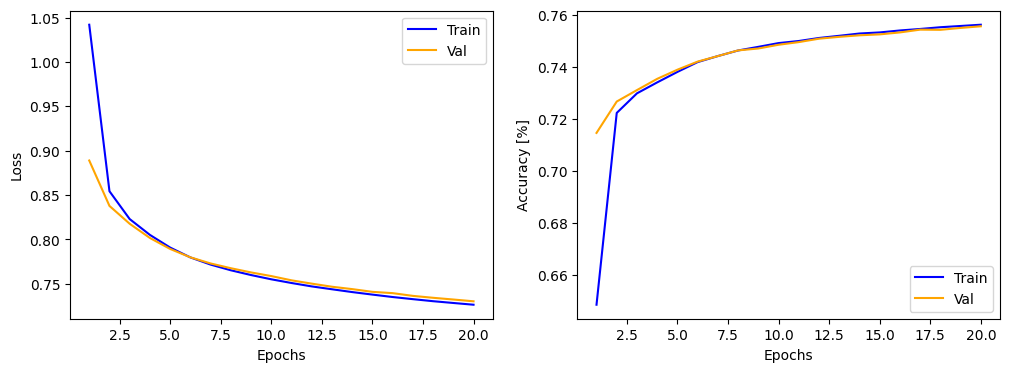

In [35]:
# Plot the training history
history = result.history

fig, axs = plt.subplots(1,2, figsize=(12,4))

epochs = np.linspace(1, N_epochs, N_epochs)
axs[0].plot(epochs, history['loss'], c='blue', label='Train')
axs[0].plot(epochs, history['val_loss'], c='orange', label='Val')
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='upper right')

axs[1].plot(epochs, history['accuracy'], c='blue', label='Train')
axs[1].plot(epochs, history['val_accuracy'], c='orange', label='Val')
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy [%]")
axs[1].legend(loc='lower right')

* What conclusions can you draw from the shape of the loss curve?
    * **Hint**: comment on overtraining/undertraining
 
This tutorial is not about obtaining the best performance for the "software" neural network classifier, so we will not spend any more time improving the performance of this network. In any case, we should evaluate the performance on the test dataset to provide a "software" baseline.

Let's first calculate the global accuracy. This is defined as the fraction of correctly classified jets:

In [59]:
y_pred_keras = model.predict(X_test)
keras_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_pred_keras, axis=1))/y_test.shape[0]

print(f"Achieved test accuracy of {(100 * keras_accuracy):.2f}%")

5188/5188 [==============================] - 4s 688us/step
Achieved test accuracy of 75.43%


### Extension
We may want to understand the performance in more detail beyond the global accuracy.

It is interesting to evaluate how the model classifies one type of jet vs another. In this extension, we will 
1) Plot the output probabilities from the neural network (multi-)classifier
2) Construct probability ratios for each class and evaluate the ROC curves
3) Plot the "confusion matrix" which tells us the fraction of predicted labels for each "truth" jet type

In [ ]:
def plot_probability(ax, X, y, features, x="zlogz", classes=['g','q','t','w','z'], bins=40):
    fi = np.where(np.array(features)==x)[0][0]
    vals = X.T[fi]

    # Obtain percentiles for sensible plot
    xlo, xhi = np.percentile(vals,0.5), np.percentile(vals,99.5)

    for i, c in enumerate(classes):
        mask = (y == c)
        ax.hist(vals[mask], bins=bins, range=(xlo,xhi), label=c, color=colors[i], histtype='step')

    ax.set_ylabel("Entries")
    ax.set_xlabel(x)
    ax.legend(loc='best')

fig, axs = plt.subplots(4,4, figsize=(20,20))
for k, feature in enumerate(features):
    i = int(np.floor(k/4))
    j = k%4
    plot_input_feature(axs[i][j], X, y, features, x=feature)

plt.show()

## Part 3: Convert the model to FPGA firmware

In this section we will convert the neural network trained with tensorflow into FPGA firmware. This is known as High-Level Synthesis (HLS) which allows us to write software-like code (e.g. in C, C++) and automatically compile it into hardware code (logic gates, registers, interconnects) that can be synthesized on an FPGA.

This tutorial uses the `hls4ml` package with an Intel OneAPI backend to do this. **TODO** Add some information here about hls4ml and OneAPI. Explain other approaches and limitations of this approach i.e. can't go all the way to synthesis.

Before starting, there's one key property of HLS which must be discussed...

### Datatypes in HLS
Fixed point representation is used instead of floating point! For example the `hls4ml` default `fixed<16,6>` corresponds to:
```
+-------------------------+---------------------------+
|  Integer part (6 bits)  | Fractional part (10 bits) |
+-------------------------+---------------------------+
| 101010                  |                1010101010 |
+-------------------------+---------------------------+
|           Full bitwidth (16 bits)                   |
+-------------------------+---------------------------+
```
**TODO** Add some more discussion here.

Read more: https://github.com/hlslibs/ac_types/blob/v3.7/pdfdocs/ac_datatypes_ref.pdf

This has important consequences for the models to be synthesized. We will even look at how we can leverage the bits used in the fixed points representation to maximize accuracy whilst minimizing the resource usage.

Let's set up the converter:

In [60]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='oneAPI')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")

WARN: Unable to import optimizer(s) from expr_templates.py: No module named 'sympy'
Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configu

What do the different items in the configuration dictionary correspond to? The most important for you to understand are:

* `Precision`: specifies the numeric format to use in the generated hardware. This choice affects both resource usage and model accuracy.
* `ReuseFactor`: controls hardware reuse, such that `1` means no reuse i.e. the design uses as many hardware resources as needed to execute all operations in parallel. The lower this factor the faster (lower latency) but more FPGA area is used
* `Strategy`: tells hls4ml to optimize for the lowest possible latency. Other strategies include `Resource`, which optimizes for minimal area.

We will now convert the keras model we trained for an Intel "Agilex7" FPGA, a family of high-end FPGAs which are designed for performance-demanding and power-efficient applications like AI acceleration. This may take a minute or so.

In [62]:
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='oneAPI', output_dir='model_1/hls4ml_prj', part='Agilex7'
)
hls_model.compile()

Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
Creating HLS model
Writing HLS project
Done
/opt/intel/oneapi/2025.0/bin/icpx
-- The CXX compiler identification is IntelLLVM 2

Now that we have converted the model, we can evaluate the accuracy. This should show little change from the "software" model.

In [63]:
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

hls_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]

In [64]:
print(f"Achieved test accuracy of {(100 * hls_accuracy):.2f}%")

Achieved test accuracy of 75.42%


### Create a report of the FPGA resource usage

Now that we have a classifier which has been converted (and compiled) for use on an FPGA, we can evaluate the resource usage to see if it is compatible with out design requirements. The report is produced in the project directory. We will will print out the key information from the build report.
* **Ignore the Seg Fault**

In [65]:
hls_model.build(build_type='report')

/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/jlangfor/local/Imperial/ICRF/teaching/AIMS25/hls4ml-aims2025/model_1/hls4ml_prj/build
[ 25%] To compile manually:
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/firmware/myproject.cpp -o CMakeFiles/report.dir/src/firmware/myproject.cpp.o
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/myproject_test.cpp -o CMakeFiles/report.dir/src/myproject_test.c

Segmentation fault (core dumped)


[100%] Built target report
['ALUTs ', 'FFs  ', 'RAMs ', 'DSPs ', 'MLABs', 'Frac. DSPs']
['974400', '1948800', '7110', '4510', '24360', '0']
[127846, 140609, 8, 31, 18, 5]


In [79]:
with open("model_1/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
    summary = ndjson.load(f)

resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summary))[0]['columns'][1:-1]
available = list(filter(lambda x: x["name"] == "Available", summary))[0]['data']
estimated_resources = list(filter(lambda x: x["name"] == "Total", summary))[0]['data']

print("~~~~~~~~~~~~~~ Resource usage ~~~~~~~~~~~~~~")
for i, resource in enumerate(resource_names):
    print(f"--> {resource}:")
    print(f"      * Available resource: {available[i]}")
    print(f"      * Used resource (estimated): {estimated_resources[i]}")
    print(f"      * Percentage of used resource (estimated): {100*float(estimated_resources[i])/float(available[i]):.2f}%")


~~~~~~~~~~~~~~ Resource usage ~~~~~~~~~~~~~~
--> ALUTs :
      * Available resource: 974400
      * Used resource (estimated): 127846
      * Percentage of used resource (estimated): 13.12%
--> FFs  :
      * Available resource: 1948800
      * Used resource (estimated): 140609
      * Percentage of used resource (estimated): 7.22%
--> RAMs :
      * Available resource: 7110
      * Used resource (estimated): 8
      * Percentage of used resource (estimated): 0.11%
--> DSPs :
      * Available resource: 4510
      * Used resource (estimated): 31
      * Percentage of used resource (estimated): 0.69%
--> MLABs:
      * Available resource: 24360
      * Used resource (estimated): 18
      * Percentage of used resource (estimated): 0.07%


What do the different resource type correspond to:
* ALUTs: adaptive look-up tables. Implement logic expressions/functions
* FFs: flip-flops. Store one bit of data; used for variables/registers
* RAMs: On-chip block RAMs. Used for storing network weights, activations etc.
* DSPs: Digital Signal Processing blocks. Optimized for multiply/add functionalities which are ideal for NN layers.
* MLABs: Memory Logic Array blocks. Small, distributed memory with lower latency and smaller capacity than RAMs.

A simple (too reductive) guide for when compiling a neural network with hls4ml. If it uses:
* Many DSPs --> You are doing lots of multiple/add operations e.g. dense layers/convolutions
* Lots of RAMs/MLABs --> You are storing many activations, weights, or intermediate values.
* High ALUT/FF usage --> Your logic is complex e.g. control flow, state machines.

<div style="background-color:#C2F5DD">
    
### Exercise

Now you have learnt how to convert a software neural network into FPGA firmware, let's see how changing the bitwidth affects the accuracy as well as resource usage.

Your task is to loop over several bitwidths and plot the accuracy and resource usage as a function of bitwidth. 

</div>

## Part 4: Quantization Aware Training

You can achieve similar performance with significantly lower bitwidths by quantizing during training.

This can be achieved with QKeras, which emulates fixed bitwidths during forward pass.



In [95]:
import qkeras
from qkeras import QDense
from qkeras.quantizers import quantized_bits

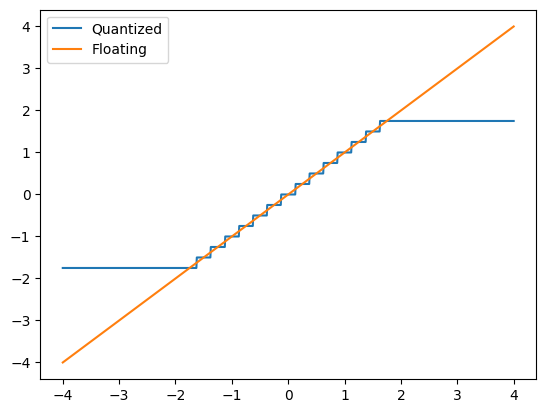

In [88]:
plt.plot(np.linspace(-4,4,1000), quantized_bits(4,1,1,alpha=1)(np.linspace(-4,4,1000)))
plt.plot(np.linspace(-4,4,1000), np.linspace(-4,4,1000))

plt.legend(["Quantized", "Floating"])


## Creating a quantized model

Using the `QDense` layer.

Requires setting `kernel_quantizer` and `bias_quantizer`

In [96]:
qmodel = Sequential()
qmodel.add(QDense(32, input_shape=(16,),
                  name='fc1',
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='relu', name='relu1'))
qmodel.add(QDense(32, 
                  name='fc2', 
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='relu', name='relu2'))
qmodel.add(QDense(32, 
                  name='fc3', 
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='relu', name='relu3'))
qmodel.add(QDense(5, 
                  name='output', 
                  kernel_quantizer = quantized_bits(4,1,1,alpha=1),
                  bias_quantizer = quantized_bits(4,1,1,alpha=1),                  
                  kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001)))
qmodel.add(Activation(activation='softmax', name='softmax'))

qmodel.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (QDense)                (None, 32)                544       
                                                                 
 relu1 (Activation)          (None, 32)                0         
                                                                 
 fc2 (QDense)                (None, 32)                1056      
                                                                 
 relu2 (Activation)          (None, 32)                0         
                                                                 
 fc3 (QDense)                (None, 32)                1056      
                                                                 
 relu3 (Activation)          (None, 32)                0         
                                                                 
 output (QDense)             (None, 5)                

In [97]:

adam = Adam(learning_rate=0.0001)
qmodel.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

qmodel.set_weights(model.get_weights())

qmodel.fit(
    X_train_val,
    y_train_val,
    batch_size=128,
    epochs=2,
    validation_split=0.25,
    shuffle=True,
)


Epoch 1/2
3891/3891 [==============================] - 15s 4ms/step - loss: 0.8152 - accuracy: 0.7306 - val_loss: 0.7713 - val_accuracy: 0.7454
Epoch 2/2
3891/3891 [==============================] - 15s 4ms/step - loss: 0.7935 - accuracy: 0.7355 - val_loss: 0.7687 - val_accuracy: 0.7445


In [98]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(qmodel, granularity='name', backend='oneAPI')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    qmodel, hls_config=config, backend='oneAPI', output_dir='model_2/hls4ml_prj', part='Agilex7'
)






Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: QDense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: QDense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'St

/home/lauri/miniconda3/envs/oneapi-env/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [99]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

hls_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]



Writing HLS project
Done
/opt/intel/oneapi/2025.0/bin/icpx
-- The CXX compiler identification is IntelLLVM 2025.0.4
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /opt/intel/oneapi/2025.0/bin/icpx - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.6s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_2/hls4ml_prj/build
[ 33%] Building CXX object CMakeFiles/lib.dir/src/firmware/myproject.cpp.o
[ 66%] Building CXX object CMakeFiles/lib.dir/src/myproject_bridge.cpp.o
[100%] Linking CXX shared library libmyproject-974ccfb0.so
[100%] Built target 

In [100]:
print(f"Achieved test accuracy of {(100 * hls_accuracy):.2f}%")


Achieved test accuracy of 74.31%


In [108]:

hls_model.build(build_type='report')
with open("model_2/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
    summary = ndjson.load(f)

resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summary))[0]['columns'][1:]
available = list(filter(lambda x: x["name"] == "Available", summary))[0]['data']
estimated_resources = list(filter(lambda x: x["name"] == "Total", summary))[0]['data']

print(resource_names)
print(available)
print(estimated_resources)

/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_2/hls4ml_prj/build
[ 25%] To compile manually:
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/firmware/myproject.cpp -o CMakeFiles/report.dir/src/firmware/myproject.cpp.o
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/myproject_test.cpp -o CMakeFiles/report.dir/src/myproject_test.cpp.o

To link manually:
/opt/intel/

Segmentation fault (core dumped)


[100%] Built target report
['ALUTs ', 'FFs  ', 'RAMs ', 'DSPs ', 'MLABs', 'Frac. DSPs']
['974400', '1948800', '7110', '4510', '24360', '0']
[34657, 38922, 8, 0, 23, 5]


<div style="background-color:#C2F5DD">


# Exercise

See how low bitwidth can still have the same accuracy as the baseline model.

Loop over several bitwidths and plot the accuracy and resource usage as a function of bitwidth.

</div>

# Pruning

Weight matrices in NNs can be huge, but not every weight contributes equally to the model performance.

Low magnitude weights can be pruned out with very small impact to the performance.

On FPGAs the weight matrices are known at compile time. Weights that are zero can be omitted by the compiler, which reduces resource usage.

To get sparse weight matrices regularization can be used to reduce weight magnitude and pruning can be then schedules to incrementaly remove and mask low magnitude weights.


In [106]:
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(0.75, begin_step=100, frequency=100)}
model = prune.prune_low_magnitude(model, **pruning_params)

In [107]:
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])

model.fit(
    X_train_val,
    y_train_val,
    batch_size=128,
    epochs=5,
    validation_split=0.25,
    shuffle=True,
    callbacks=[pruning_callbacks.UpdatePruningStep()],
)


Epoch 1/5
3891/3891 [==============================] - 12s 3ms/step - loss: 0.7687 - accuracy: 0.7402 - val_loss: 0.7458 - val_accuracy: 0.7475
Epoch 2/5
3891/3891 [==============================] - 12s 3ms/step - loss: 0.7353 - accuracy: 0.7494 - val_loss: 0.7324 - val_accuracy: 0.7505
Epoch 3/5
3891/3891 [==============================] - 11s 3ms/step - loss: 0.7242 - accuracy: 0.7522 - val_loss: 0.7234 - val_accuracy: 0.7526
Epoch 4/5
3891/3891 [==============================] - 13s 3ms/step - loss: 0.7148 - accuracy: 0.7547 - val_loss: 0.7151 - val_accuracy: 0.7551
Epoch 5/5
3891/3891 [==============================] - 16s 4ms/step - loss: 0.7089 - accuracy: 0.7563 - val_loss: 0.7101 - val_accuracy: 0.7555


In [112]:
# Strip pruning

model = strip_pruning(model)

In [135]:
for i, l in zip(model.get_weights(), model.layers):
    print(f"{np.sum(i.flatten()==0)/i.flatten().shape[0]*100:.1f}% sparsity for layer {l.name}")

75.0% sparsity for layer fc1
0.0% sparsity for layer relu1
75.0% sparsity for layer fc2
0.0% sparsity for layer relu2
75.0% sparsity for layer fc3
0.0% sparsity for layer relu3
75.0% sparsity for layer output
0.0% sparsity for layer softmax


In [128]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model', backend='oneAPI')
print("-----------------------------------")
print("Configuration")
print(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, backend='oneAPI', output_dir='model_3/hls4ml_prj', part='Agilex7'
)






Interpreting Sequential
Topology:
Layer name: fc1_input, layer type: InputLayer, input shapes: [[None, 16]], output shape: [None, 16]
Layer name: fc1, layer type: Dense, input shapes: [[None, 16]], output shape: [None, 32]
Layer name: relu1, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc2, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu2, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: fc3, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: relu3, layer type: Activation, input shapes: [[None, 32]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 5]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 5]], output shape: [None, 5]
-----------------------------------
Configuration
{'Model': {'Precision': {'default': 'fixed<16,6>'}, 'ReuseFactor': 1, 'Strate

In [129]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

hls_accuracy = np.sum(np.argmax(y_test, axis=1) == np.argmax(y_hls, axis=1))/y_test.shape[0]



Writing HLS project
Done
/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_1/hls4ml_prj/build
[ 33%] Building CXX object CMakeFiles/lib.dir/src/firmware/myproject.cpp.o
[ 66%] Building CXX object CMakeFiles/lib.dir/src/myproject_bridge.cpp.o
[100%] Linking CXX shared library libmyproject-f833531a.so
[100%] Built target lib


In [130]:
print(f"Achieved test accuracy of {(100 * hls_accuracy):.2f}%")


Achieved test accuracy of 75.50%


In [131]:

hls_model.build(build_type='report')
with open("model_3/hls4ml_prj/build/myproject.report.prj/reports/resources/json/summary.ndjson", "r") as f:
    summary = ndjson.load(f)

resource_names = list(filter(lambda x: x["name"] == "Estimated Resource Usage", summary))[0]['columns'][1:]
available = list(filter(lambda x: x["name"] == "Available", summary))[0]['data']
estimated_resources = list(filter(lambda x: x["name"] == "Total", summary))[0]['data']

print(resource_names)
print(available)
print(estimated_resources)

/opt/intel/oneapi/2025.0/bin/icpx
-- Configuring the design to run on FPGA board Agilex7
-- Additional USER_FPGA_FLAGS=-Wno-unused-label
-- Additional USER_FLAGS=-Wno-unused-label;-fconstexpr-steps=134217728
-- Additional USER_INCLUDE_PATHS=src;src/firmware
-- Additional USER_LIB_PATHS=
-- Additional USER_LIBS=
-- Configuring done (0.0s)
-- Generating done (0.0s)
-- Build files have been written to: /home/lauri/local/icl/notebooks/model_1/hls4ml_prj/build
[ 25%] To compile manually:
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/firmware/myproject.cpp -o CMakeFiles/report.dir/src/firmware/myproject.cpp.o
/opt/intel/oneapi/2025.0/bin/icpx -I../src -I../src/firmware -fsycl -fintelfpga -Wall -qactypes -Wno-unused-label -fconstexpr-steps=134217728 -DFPGA_HARDWARE -c ../src/myproject_test.cpp -o CMakeFiles/report.dir/src/myproject_test.cpp.o

To link manually:
/opt/intel/

icpx: warning: appending to an existing archive 'myproject.report' [-Warchive-append]
Segmentation fault (core dumped)


[100%] Built target report
['ALUTs ', 'FFs  ', 'RAMs ', 'DSPs ', 'MLABs', 'Frac. DSPs']
['974400', '1948800', '7110', '4510', '24360', '0']
[42837, 47838, 8, 5, 19, 5]


<div style="background-color:#C2F5DD">


# Exercise

Train models with different sparsity. Plot the performance and resource usage as function of model sparsity.

How large are the savings in resource usage in comparison to the baseline model before accuracy drops?

</div>

<div style="background-color:#C2F5DD">


# Exercise

Train and synthesize model that uses both quantization aware training and pruning that achieves the same accuracy as the baseline model.

How large are the savings in resource usage in comparison to the baseline model before accuracy drops?

</div>